# load libraries

In [ ]:
!pip install pystac_client
!pip install planetary_computer
!pip install leafmap
!pip install geogif
!pip install stackstac
!pip install dask distributed

  Using cached stackstac-0.5.1-py3-none-any.whl.metadata (8.1 kB)
  Using cached rasterio-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached stackstac-0.5.1-py3-none-any.whl (64 kB)
Using cached rasterio-1.4.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.2 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)


In [ ]:
!pip install rasterio
!pip install dask_gateway

In [ ]:
# !pip install xrspatial.multispectral
# !pip install xrspatial

ERROR: Could not find a version that satisfies the requirement xrspatial.multispectral (from versions: none)
ERROR: No matching distribution found for xrspatial.multispectral
ERROR: Could not find a version that satisfies the requirement xrspatial (from versions: none)
ERROR: No matching distribution found for xrspatial


In [ ]:
import dask
import pystac_client
import planetary_computer as pc
import leafmap
import geogif
import stackstac
import dask.array as da
import distributed

In [ ]:
# start dask cluster
from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)
# client

In [ ]:
client = distributed.Client()

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41463
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42819'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33275'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42673', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42673
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:44148
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33127', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker co

# select bounding box

In [ ]:
# m = leafmap.Map(center=[62.4776899, -42.9212268], zoom=13, height="800px") # mark5
# m = leafmap.Map(center=[62.4574055, -42.8332964], zoom=13, height="800px") # mark4
# m = leafmap.Map(center=[62.4402846, -42.7274093], zoom=13, height="800px") # mark3
m = leafmap.Map(center=[62.4160264, -42.6219019], zoom=13, height="800px") # mark6
# m = leafmap.Map(center=[62.3845266, -42.5135630], zoom=13, height="800px") # mark7
# m = leafmap.Map(center=[62.6994187, -43.0282930], zoom=13, height="800px") # mark8
# m = leafmap.Map(center=[62.6774923, -42.8389669], zoom=13, height="800px") # mark9
# m = leafmap.Map(center=[62.6500464, -42.6585083], zoom=13, height="800px") # mark10
m

Map(center=[62.4160264, -42.6219019], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [ ]:
bbox = (m.west, m.south, m.east, m.north)
bbox

(-42.68960952758789,
 62.384243030434085,
 -42.55416870117188,
 62.447832962833175)

# download sentinel-2

In [ ]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')

# List available collections to verify collection names
# collections = catalog.get_all_collections()
# print("Available Collections:")
# for coll in collections:
#     print(coll.id)

In [ ]:
search = catalog.search(
    datetime="2022-05-01/2022-09-01",
    # datetime="2022-05-22",
    bbox=bbox,
    collections=["sentinel-2-l2a"],
)
items = pc.sign(search)
len(items)

148

In [ ]:
stack = stackstac.stack(items, bounds_latlon=bbox, resolution=30, epsg=32627)

In [ ]:
scl = stack.sel(band=["scl"])

# Sentinel-2 Scene Classification Map: nodata, saturated/defective, dark, cloud shadow, cloud med. prob., cloud high prob., cirrus
invalid = da.isin(scl, [0, 1, 2, 3, 8, 9, 10])
valid = stack.where(~invalid)

rgb = valid.sel(band=["red","green","blue"])

quarterly = rgb.resample(time="W").median()

In [ ]:
ts = quarterly.persist()
ts_local = ts.compute()

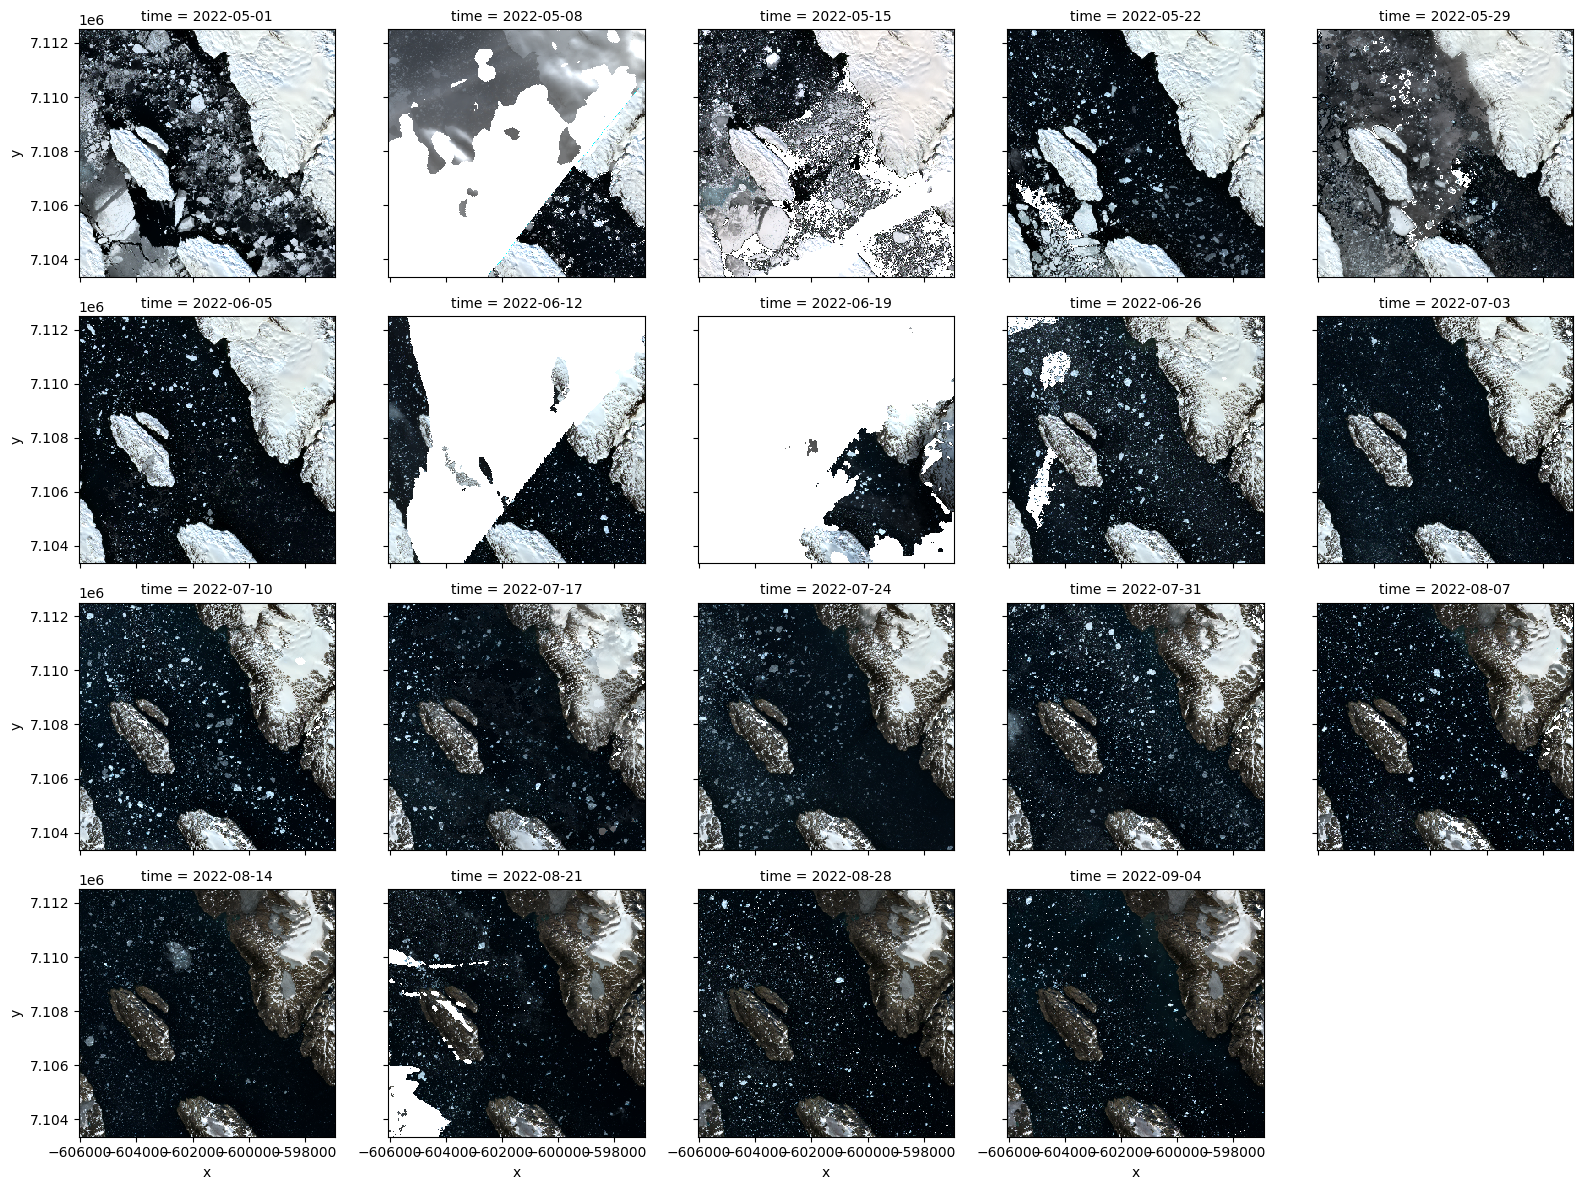

In [ ]:
ts_local.plot.imshow(col="time", rgb="band", col_wrap=5, robust=True)

# save image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os

# Loop over each time step in the DataArray
for i, time_step in enumerate(ts_local['time']):
    # Select the data for the current time step
    img_data = ts_local.sel(time=time_step)

    # Create the plot and get the current axis
    fig, ax = plt.subplots()
    img_data.plot.imshow(ax=ax, rgb="band", robust=True)
    # Remove the x and y axis labels and ticks
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Remove the title
    # ax.set_title('')

    # Save the current figure as a separate file
    path = '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/mark8_22/'
    filename = f"{i}.jpg"
    plt.savefig(os.path.join(path, filename), dpi=1000, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free memory

    # Optionally, print the filename to confirm saving
    # print(f"Saved {filename}")

Saved 0.jpg
Saved 1.jpg
Saved 2.jpg
Saved 3.jpg
Saved 4.jpg
Saved 5.jpg
Saved 6.jpg
Saved 7.jpg
Saved 8.jpg
Saved 9.jpg
Saved 10.jpg
Saved 11.jpg
Saved 12.jpg
Saved 13.jpg
Saved 14.jpg
Saved 15.jpg
Saved 16.jpg
Saved 17.jpg
Saved 18.jpg
Saved 19.jpg
Saved 20.jpg
Saved 21.jpg
Saved 22.jpg
Saved 23.jpg
Saved 24.jpg
Saved 25.jpg
Saved 26.jpg


# save as tif

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os

# Loop over each time step in the DataArray
for i, time_step in enumerate(ts_local['time']):
    # Select the data for the current time step
    img_data = ts_local.sel(time=time_step)
    # img_data.rio.write_crs(EPSG_CODE, inplace=True) # https://corteva.github.io/rioxarray/stable/getting_started/crs_management.html
    # you might need to assing CRS manually
    img_data.rio.to_raster("your path.tif") # how to save to a tif with affine transformation # data array
    # Create the plot and get the current axis
    fig, ax = plt.subplots()
    img_data.plot.imshow(ax=ax, rgb="band", robust=True)

    # Remove the x and y axis labels and ticks
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Save the current figure as a TIFF file
    path = f'/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/4/'
    if not os.path.exists(path):
        os.makedirs(path)

    filename = f"{i}.tif"  # Change extension to .tif
    plt.savefig(os.path.join(path, filename), format='tiff', dpi=1000, bbox_inches='tight', pad_inches=0) # geospatial
    plt.close()  # Close the figure to free memory

    # Optionally, print the filename to confirm saving
    # print(f"Saved {filename}")

# add affine transformation

In [ ]:
import rasterio
from rasterio.transform import from_origin

In [ ]:
# Specify the transformation parameters
# Example origin coordinates (upper-left corner of the image) and resolution (pixel size)
west, north = -42.6219019, 62.4160264 # Replace with actual coordinates
pixel_size = 1000  # Replace with actual pixel resolution if known
transform = from_origin(west, north, pixel_size, pixel_size)

# Open saved TIFF and add affine transform
path = '/content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/'
output_path = os.path.join(path, '44.tif')
filename = '4.tif'

with rasterio.open(os.path.join(path, filename)) as src:
    meta = src.meta.copy()
    meta.update({
        'transform': transform,
        'crs': 'EPSG:4326'  # Set appropriate CRS, such as WGS84
    })

    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(src.read())

print("Saved image with affine transformation at:", output_path)

Saved image with affine transformation at: /content/drive/MyDrive/icebergtrack/iceberg_sentinel/tif/merge/44.tif
